<a href="https://colab.research.google.com/github/keresztesbeata/Computer-Vision-Projects/blob/main/deep_dream/DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import IPython.display as display
import PIL.Image
import os
from os import listdir

### Load the image data

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 32

In [8]:
def load_image(path):
  img = PIL.Image.open(path)
  # downsize the image to enforce a uniform dimension
  img.thumbnail((IMG_HEIGHT, IMG_WIDTH))
  # convert the image to an array
  img = np.array(img)

  return img 

In [4]:
def show_image(img):
  # convert the image to an array
  img = np.array(img)
  # load image from array
  img = PIL.Image.fromarray(img)
  # display image
  display.display(img)

In [7]:
from google.colab import drive
drive.mount("/content/gdrive")

original_data_path = "/content/gdrive/MyDrive/Computer Vision/deepdream/original"
result_data_path = "/content/gdrive/MyDrive/Computer Vision/deepdream/result"

Mounted at /content/gdrive


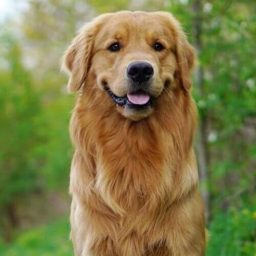

In [74]:
# show the original image
image_path = original_data_path + "/golden.jpg"
original_img = load_image(image_path)
show_image(original_img)

### Create the model




Use the InceptionV3 feature extraction model as a base:

In [10]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 1s 0us/step


Choose a layer and maximize the "loss" s.t. the image increasingly "excites" the layer.
Complexity of the features depends on the layer chosen:
 - lower layers produce simple patterns, strokers (ex. edges, shapes, textures)
 - deeper layers produce sophisticated features or whole objects (ex. eyes, faces)

Layers of interest = where convolutions are concatenated => 11 such layers in InceptionV3 [mixed0..mixed10]

Different layers result in different "dream-like" images.

In [11]:
def create_model(base_model, layer_names):
  """
  """
  # maximize the activation of the selected layers
  layers = [base_model.get_layer(name).output for name in layer_names]
  
  # create the feature extraction model
  dream_model = tf.keras.Model(inputs = base_model.input, outputs = layers)

  return dream_model

### Calculate the loss


The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution of larger layers doesn't outweight smaller layers.

Normally, the loss is minimized via gradient descent, but in DeepDream we will maximize the loss via _gradient ascent_.

In [12]:
def calc_loss(img, model):
  """
  Padd forward the image throught the model to retrieve the activations.
  """
  # convert the image into a batch of size 1, because the model only accepts batch of images
  img_batch = tf.expand_dims(img, axis=0)
  # get the activations from the layer
  activations = model(img_batch)
  # if there is just 1 output of the activation layer then convert it to an array
  if len(activations) == 1:
    activations = [activations]

  # initilaize the losses array
  losses = []
  for activation in activations:
    # normalize the loss
    loss = tf.math.reduce_mean(activation)
    # add the computed loss to the result
    losses.append(loss)
  
  # sum up the total losses
  total_loss = tf.reduce_sum(losses)

  return total_loss

### Gradient ascent


Calculate the gradient ascent of the original image and add them to the original image.
> Adding gradients to the image enhances the patterns seen by the network. At each step we create an image that increasingly excites the activation of certain layers in the network.

Wrap the method in tf.function for better performance. _input_signature_ ensures that the function is not retraced for different image sizes or steps/step_size values.

GradientTape is used for _automatic differentiation_.
- TensorFlow needs to remember what operations happen in what order during the _forward pass_.
- During the _backward pass_ it traverses the list of operations in reverse order to compute the gradients.

GradientTape records the relevant operations executedinside the context on a "tape" and uses this tape to compute the gradients using _reverse mode differentiation_.

Ex y = x**2 ---reverse diff---> dy = 2x*dx => grad = dy/dx

In [13]:
class DeepDream(tf.Module):
  def __init__(self, model):
    # the model contains the selected activation layers
    self.model = model

  @tf.function(
      input_signature=(
          tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
          tf.TensorSpec(shape=[], dtype=tf.int32),
          tf.TensorSpec(shape=[], dtype=tf.float32),
      )
  )
  def __call__(self, img, steps, step_size):
    """
    Runs gradient ascent algorithm on the given batch of images using the predefined model.

    - img = image tensor on which the model is trained
    - steps = number of updates to the image (traversals)
    - step_size = learning rate

    Returns:
    (loss, img) = pair of computed loss and the updated image
    """

    print("Tracing gradient ascent")
    loss = tf.constant(0.0)

    for n in tf.range(steps):
      # we need gradients relative to img
      with tf.GradientTape() as tape:
        # GradientTape only watches trainable variables (tf.Variable)
        tape.watch(img)

        loss = calc_loss(img, self.model)
      
        # calculate the gradient of the loss w.r.t. pixels of the image
        gradients = tape.gradient(loss, img)

        # normalize the gradients (add a default offset to avoid 0 gradients)
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        # Maximize the loss s.t. the input image increasingly "excites" the layers
        # add the gradients to the image (same shape)
        img = img + gradients * step_size
        # saturate values to be in the range [-1,1]
        img = tf.clip_by_value(img, -1, 1)

    return loss, img

In [35]:
# select some layers
layers = ['mixed3', 'mixed5']
# initialize the model with the selected layers
model = create_model(base_model, layers)
# create the deep dream model
deep_dream_model = DeepDream(model)

In [15]:
def normalize(img):    
    # normalize the image (histogram stretching) to correct poor contrast
    img = 255 * (img + 1.0) / 2.0
    img = tf.cast(img, tf.uint8)

    return img

In [36]:
def run_model(deep_dream_model, img, steps = 100, step_size = 0.01):
  """
  Run the deep dream model on the given image for 'steps' nr of steps and with learning rate given by 'step_size'.
  """

  # convert from uint8 to the range expected by the model [0,1]
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  # convert the image array to a tensor
  img = tf.convert_to_tensor(img)
  # convert the value to a tensor constant
  step_size = tf.convert_to_tensor(step_size)
  # keep track of remaining steps
  remaining_steps = steps
  # current step
  curr_step = 0

  while remaining_steps:
    # compute the nr of steps to run (cannot be grater than max nr of steps)
    steps_to_run = remaining_steps if remaining_steps <= steps else steps
    # convert the value to a tensor constant
    steps_to_run = tf.constant(steps_to_run)  
    # update the remaining nr of steps
    remaining_steps -= steps_to_run
    # update the current step
    curr_step += steps_to_run

    print("Starting deep dream algorithm")

    # run gradient ascent on the loss array and update the image
    loss, img = deep_dream_model(img, steps_to_run, tf.constant(step_size))

    print("Finished deep dream algorithm")

    # clear the console output
    display.clear_output(wait=True)
     
    # show the intermediate image after each step
    show_image(normalize(img))
    print("Step ", curr_step)
    # print("Loss {}".format(loss))

  result = normalize(img)
  # clear the console output
  display.clear_output(wait=True)
  # show the final resulting image
  show_image(result)

  return result

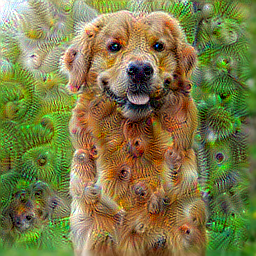

In [37]:
# test out the model
dream_img = run_model(deep_dream_model=deep_dream_model,
                      img=original_img,
                      steps=100, 
                      step_size=0.01)

Problems:
 - output is noisy
 - image is low resolution
 - patterns appear at the same granularity

Solution:
 - apply gradient ascent at different scales s.t. patterns generated at lower scales will be incorporated into patterns generated at higher scales
 - increase the size of the image (octave) and repeat the process for multiple octaves

In [38]:
def run_enhanced_model(deep_dream_model, original_img, steps = 100, step_size = 0.01):
  """
  Run the model and update the image for multiple octaves.
  """
  OCTAVE_SCALE = 1.3

  # convert the original image to a tensor constant array
  img = tf.constant(np.array(original_img))
  # get the dimension of the image (height, width, 3) except the last element
  base_shape = tf.shape(img)[:-1]
  # cast the size of the image to float
  float_base_shape = tf.cast(base_shape, tf.float32)

  for n in range (-2,3):
    # compute the new img shape by multiplying the base shape with a power of the OCTAVE_SCALE
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
    # resize the image to fit the newshape
    img = tf.image.resize(img, new_shape).numpy()
    # run the deep dream algorithm on the image with the new shape
    img = run_model(deep_dream_model=deep_dream_model,
                    img=original_img,
                    steps=steps, 
                    step_size=step_size)
    
  # clear the console
  display.clear_output(wait=True)
  # convert the image back to its original shape
  img = tf.image.resize(img, base_shape)
  # normalize and convert the pixel values back to integers
  img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
  # display the result
  show_image(img)

  return img

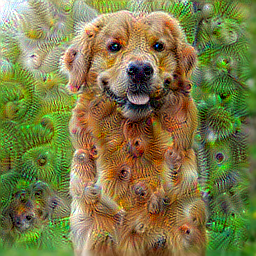

In [39]:
# test the enhanced model and compare it with the previous result
enhanced_dream_img = run_enhanced_model(
    deep_dream_model=deep_dream_model,
    original_img=original_img,
    steps=100, 
    step_size=0.01)

In [119]:
def show_compare_result(original_img, dream_img):
  """
  Display the obtained images side-by-side.
  """
  fig = plt.figure(figsize=(10, 7))

  # add a subplot at the 1st position
  fig.add_subplot(1, 2, 1)
  plt.imshow(original_img)
  plt.axis('off')
  plt.title("Original image")

  # add a subplot at the 2nd position
  fig.add_subplot(1, 2, 2)
  plt.imshow(dream_img)
  plt.axis('off')
  plt.title("Deep dream image")

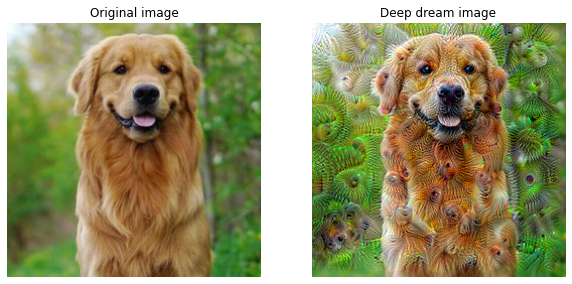

In [120]:
show_compare_result(original_img, dream_img)

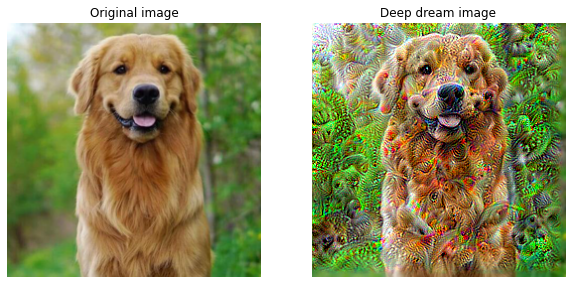

In [121]:
show_compare_result(original_img, enhanced_dream_img)

> As we can see, by enhancing the previous algorithm, and running the model multiple times for an image with different octave scales, we can reuse the identified low-level patterns in the lower scale image in order to identify higher level patterns from the higher scale image. 
> The resulting image has higher resolution and the "eyes" are less evident in the background of the image.

### Create other deep dream models using different activation layers

Display all the layers of the inception_v3 model (it is 48 layers deep):

In [44]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

We are only interested in the activation layers. Thus, we look at the mixed layers which concatenate multiple activation layers and select from these:

In [55]:
# select the mixed layers from the model
mixed_layers = [layer for layer in base_model.layers if isinstance(layer, tf.keras.layers.Concatenate)]
# list the names of these models
for mixed_layer in mixed_layers:
  print(mixed_layer.name)

mixed0
mixed1
mixed2
mixed3
mixed4
mixed5
mixed6
mixed7
mixed8
mixed9_0
concatenate
mixed9
mixed9_1
concatenate_1
mixed10


##### Using only low level layers

Generate a deep dream image by using the activations of low level layers. This would enhance the low-level shapes such as strokes, basic shapes, textures.

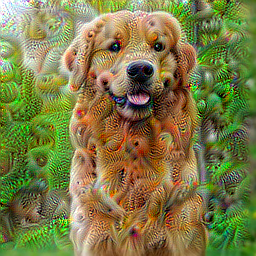

In [58]:
# select some low-level layers
ll_layers = ['mixed0', 'mixed1', 'mixed2']
# initialize the low-level model with the selected layers
ll_model = create_model(base_model, ll_layers)
# create the deep dream model
ll_deep_dream_model = DeepDream(ll_model)

# run the enhanced model using the low-level layers on the original image
enhanced_dream_img = run_enhanced_model(
    deep_dream_model=ll_deep_dream_model,
    original_img=original_img,
    steps=100, 
    step_size=0.01)

> The obtained image is overlapped by many curves, lines and fur-like texture. This shows what that the neuron's at certain positions look for when analying the low-level patterns in the image.

#### Using only high-level layers

Generate a deep dream image by using only high-level activation layers in order to enhance complex features, such as eyes, face or whole objects:

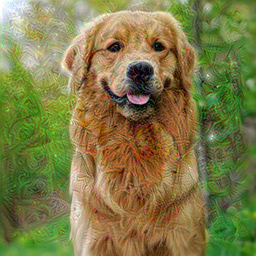

In [61]:
# select some high-level layers
hl_layers = ['mixed8', 'mixed9', 'mixed10']
# initialize the high-level model with the selected layers
hl_model = create_model(base_model, hl_layers)
# create the deep dream model
hl_deep_dream_model = DeepDream(hl_model)

# run the enhanced model using the high-level layers on the original image
enhanced_dream_img = run_enhanced_model(
    deep_dream_model=hl_deep_dream_model,
    original_img=original_img,
    steps=100, 
    step_size=0.01)

> The output obtained with higher-level layers resembles more the original image, the patterns which excite the neurons are less evident in this case, which confirms the idea that these layers look for more complex features in the image.

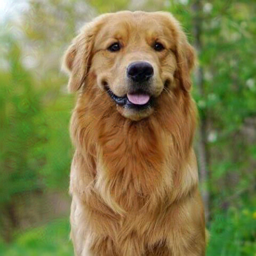

In [64]:
# run the same high-level model but with smaller learning rate
enhanced_dream_img = run_enhanced_model(
    deep_dream_model=hl_deep_dream_model,
    original_img=original_img,
    steps=100, 
    step_size=0.001)

> The obtained image at lower learning rate is almost like the original, which means the updates from the actvation layers were very low.

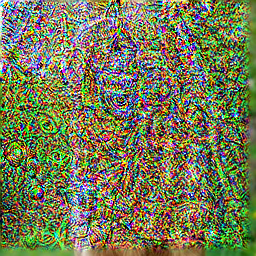

In [65]:
# run the same high-level model but with bigger learning rate
enhanced_dream_img = run_enhanced_model(
    deep_dream_model=hl_deep_dream_model,
    original_img=original_img,
    steps=100, 
    step_size=0.1)

> The result is unrecognizable, because of the too high learning rate the updates from the activation layers are too high, as shown on the image by the vivid noise-like pattern which distort the original image.

#### Using a combinination of low-level and high-level activation layers

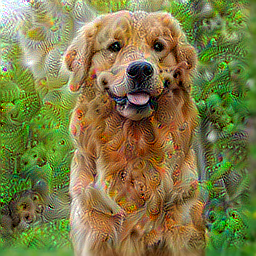

In [66]:
# select some low-level and high-level layers
cm_layers = ['mixed0', 'mixed2', 'mixed6']
# initialize the model with the selected layers
cm_model = create_model(base_model, cm_layers)
# create the deep dream model
cm_deep_dream_model = DeepDream(cm_model)

# run the enhanced model using the low-level and high-level layers on the original image
enhanced_dream_img = run_enhanced_model(
    deep_dream_model=cm_deep_dream_model,
    original_img=original_img,
    steps=100, 
    step_size=0.01)

> On the obtained image we can see the updates that result from the activation layers, additionally a lot of "eye" or "nose" like patterns can be observed aside from the "fur-like" texture which covers the whole image.

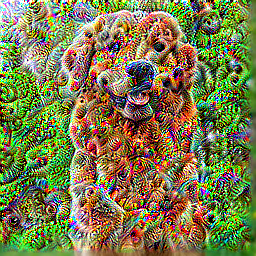

In [67]:
# select some low-level and high-level layers
cm_layers = ['mixed0', 'mixed2', 'mixed6']
# initialize the model with the selected layers
cm_model = create_model(base_model, cm_layers)
# create the deep dream model
cm_deep_dream_model = DeepDream(cm_model)

# run the enhanced model using the low-level and high-level layers on the original image
enhanced_dream_img = run_enhanced_model(
    deep_dream_model=cm_deep_dream_model,
    original_img=original_img,
    steps=100, 
    step_size=0.05)

> Running the same model but with a little higher learning rate resulted in larger updates to the image.

Finally, we select some low-level layers and a higher-level one and use a slightly bigger learning rate in order to obtain an "interesting", visually intriguing image.

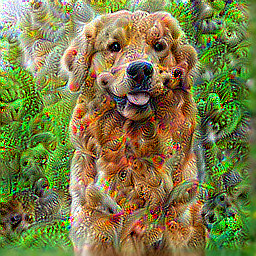

In [81]:
# select some low-level and high-level layers
fin_layers = ['mixed0', 'mixed2', 'mixed6']
# initialize the model with the selected layers
fin_model = create_model(base_model, fin_layers)
# create the deep dream model
fin_deep_dream_model = DeepDream(fin_model)

# run the enhanced model using the low-level and high-level layers on the original image
golden_dream_img = run_enhanced_model(
    deep_dream_model=fin_deep_dream_model,
    original_img=original_img,
    steps=100, 
    step_size=0.02)

In [106]:
def save_image(tf_img, path):
  # convert tensor to numpy array
  img = np.array(tf_img)
  tf.keras.utils.save_img(path, img)

In [108]:
save_image(golden_dream_img, result_data_path + '/golden.jpg')

We try out the selected model on different images:

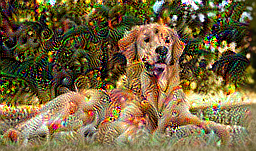

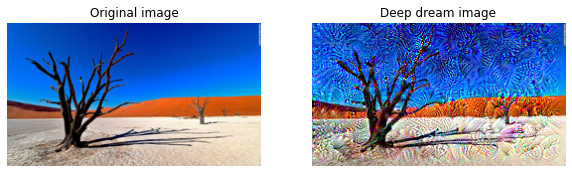

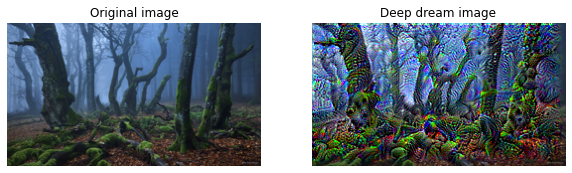

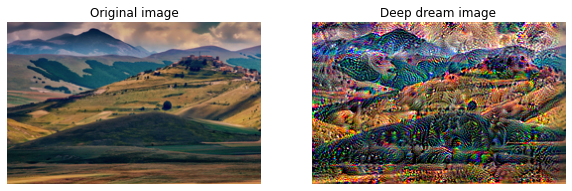

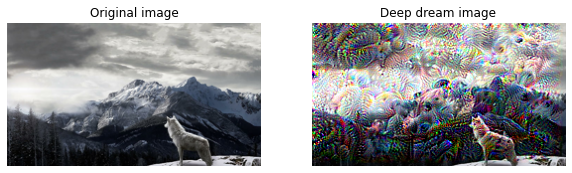

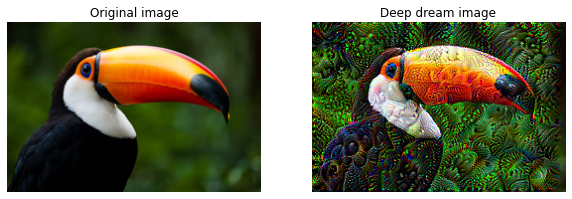

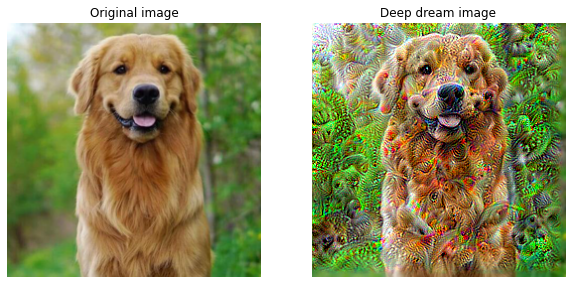

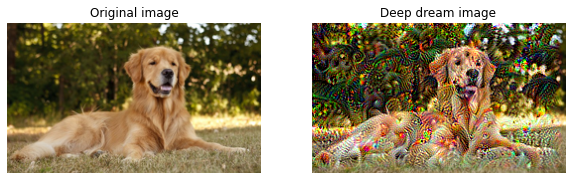

In [123]:
# loop through all the images from the data dir
for image in os.listdir(original_data_path):
    # check if the image ends with jpg
    if (image.endswith(".jpg")):
      # get the file path
      full_path = os.path.join(original_data_path, image)
      print(full_path)
      # load the image data
      original = load_image(full_path)
      # run the model
      result = run_enhanced_model(
          deep_dream_model=fin_deep_dream_model,
          original_img=original,
          steps=100, 
          step_size=0.02
          )
      # show the result compared to the original
      show_compare_result(original, result)
      # construct the whole path
      result_path = os.path.join(result_data_path, image)
      # save the resulting image
      save_image(result, result_path)